## Notebook for dose response curves

In [698]:
import os
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.interpolate import interp1d

from causal_curve import GPS_Regressor
from causal_curve import Mediation


%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]
pd.options.mode.chained_assignment = None  # default='warn'

load data

In [699]:
df = pd.read_csv('data/main/data_set.csv')

In [700]:
df = df[df['quick_ratio_2021'] < 15 ]
df = df[df['quick_ratio_2021'] > 0 ]
df = df[df['quick_ratio_2020'] < 15 ]
df = df[df['quick_ratio_2020'] > 0 ]

df = df[df['current_ratio_2021'] < 15 ]
df = df[df['current_ratio_2021'] > 0 ]
df = df[df['current_ratio_2020'] < 15 ]
df = df[df['current_ratio_2020'] > 0 ]

In [701]:
df['grant_relative_2021'] = df['aid_grant_2021'] / df['assets_2021']
df['loan_relative_2021'] = df['aid_loan_2021'] / df['assets_2021']
df['loan_relative_2020'] = df['aid_loan_2020'] / df['assets_2020']
df['delta_cash_ratio_2021'] = (df['cash_ratio_2021'] - df['cash_ratio_2020'])
df['delta_cash_ratio_2020'] = (df['cash_ratio_2020'] - df['cash_ratio_2019'])
df['delta_cash_2021'] = (df['cash_2021'] - df['cash_2020'])
df['delta_cash_2020'] = (df['cash_2020'] - df['cash_2019'])
df['delta_debt/asset_ratio_2021'] = (df['debt/asset_ratio_2021'] - df['debt/asset_ratio_2020'])
df['delta_equity/asset_ratio_2021'] = (df['debt/equity_ratio_2021'] - df['debt/equity_ratio_2020'])
df['delta_debt/asset_ratio_2020'] = (df['debt/asset_ratio_2020'] - df['debt/asset_ratio_2019'])

In [702]:
df = df[['delta_cash_ratio_2021',
         'delta_cash_ratio_2020',
         'debt/asset_ratio_2020',
         'size',    
         'delta_cash_2021',
         'delta_cash_2020',
         'aid_grant_2021',
         'aid_grant_2020',
         'aid_loan_2021',
         'days_grant_2020',
         'days_loan_2020',
         'days_grant_2021',
         'days_loan_2021',
         'aid_loan_2020',
         'assets_2020',
         'assets_2019',
         'loan_relative_2021',
         'loan_relative_2020',
         'delta_debt/asset_ratio_2021',
         'delta_debt/asset_ratio_2020',
         'delta_equity/asset_ratio_2021',
         'grant_relative_2021',
         'industry']]


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.replace(np.nan, 0, inplace=True)
df['days_loan_2021'] = pd.to_numeric(df['days_loan_2021'])
df['days_loan_2020'] = pd.to_numeric(df['days_loan_2021'])


final_df = pd.concat([df,pd.get_dummies(df["size"], prefix='size', drop_first=True)],axis = 1)
final_df.columns = final_df.columns.str.replace(' ', '_')

final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df = final_df.dropna()

final_df = final_df[final_df['delta_cash_2021'].between(*final_df['delta_cash_2021'].quantile([0.05, 0.95]).tolist())]
final_df = final_df[final_df['grant_relative_2021'].between(*final_df['grant_relative_2021'].quantile([0.0, 0.95]).tolist())]


In [703]:
condounders = pd.get_dummies(df["size"], prefix='size', drop_first=True)
condounders.columns = condounders.columns.str.replace(' ', '_')

### Liquidity

In [704]:
potential_confounders_1=[]
potential_confounders_2=[]
potential_confounders_3=[]
potential_confounders_4=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)


# Try the model with cash_ratio / grants

# Potential confounders
potential_confounders_1 = potential_confounders + ['loan_relative_2021'] + ['days_grant_2021'] + ['debt/asset_ratio_2020']
#potential_confounders_1.append('aid_loan_2021')
#potential_confounders_1.append('days_grant_2021')

cash_ratio_grant_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_grant_gps.fit(
    T=final_df['grant_relative_2021'], 
    X=final_df[potential_confounders_1], 
    y=final_df['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant'] = cash_ratio_grant_gps.calculate_CDRC(.95)



# Try the model with cash_ratio / loans

# Potential confounders
potential_confounders_2 = potential_confounders + ['days_loan_2020'] + ['aid_loan_2020']

cash_ratio_loan_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_loan_gps.fit(
    T=final_df['loan_relative_2020'], 
    X=final_df[potential_confounders_2], 
    y=final_df['delta_cash_ratio_2020']
)
results_dict['cash_ratio_loan'] = cash_ratio_loan_gps.calculate_CDRC(.95)

# Try the model with cash absolut / grants

# Potential confounders
potential_confounders_3 = potential_confounders + ['aid_loan_2021'] + ['days_grant_2021'] + ['assets_2020'] + ['aid_loan_2020'] +['debt/asset_ratio_2020']

cash_abs_grant_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95, gps_family='lognormal')
cash_abs_grant_gps.fit(
    T=final_df['aid_grant_2021'], 
    X=final_df[potential_confounders_3], 
    y=final_df['delta_cash_2021']
)
results_dict['cash_abs_grant'] = cash_abs_grant_gps.calculate_CDRC(.95)



# Try the model with cash absolut / loans

# Potential confounders
potential_confounders_4 = potential_confounders + ['aid_grant_2020'] + ['days_loan_2020'] + ['assets_2019']

cash_abs_loan_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95, gps_family='lognormal')
cash_abs_loan_gps.fit(
    T=final_df['aid_loan_2020'], 
    X=final_df[potential_confounders_4], 
    y=final_df['delta_cash_2020']
)
results_dict['cash_abs_loan'] = cash_abs_loan_gps.calculate_CDRC(.95)


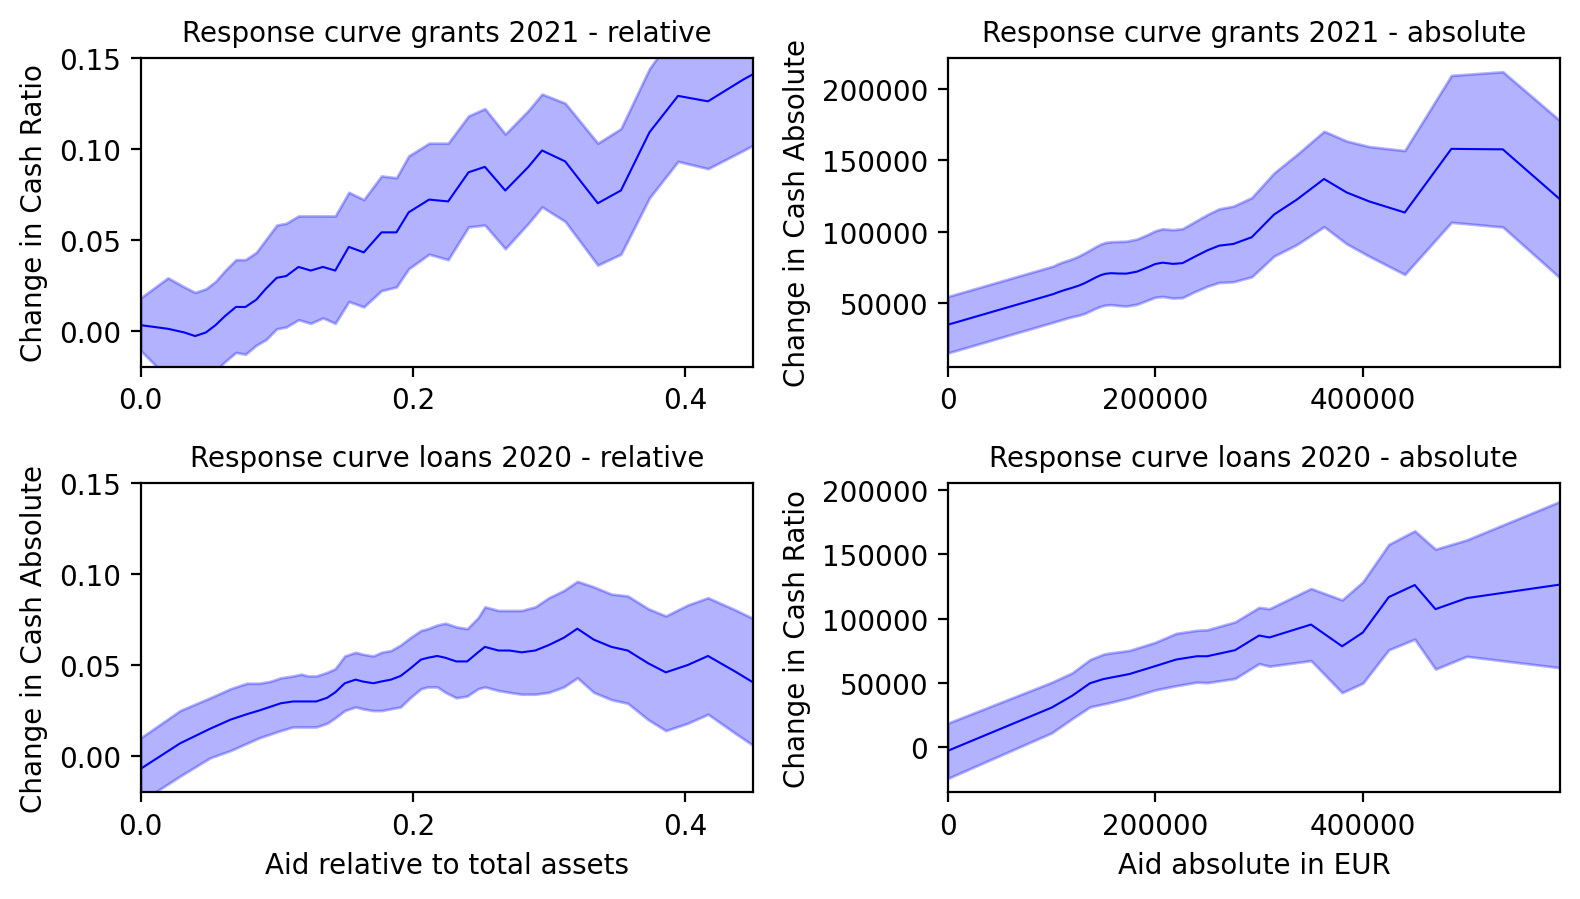

In [712]:
result_class = [['cash_ratio_grant', 'cash_abs_grant'], ['cash_ratio_loan', 'cash_abs_loan']]
result_name = [['Response curve grants 2021 - relative', 'Response curve grants 2021 - absolute'], ['Response curve loans 2020 - relative', 'Response curve loans 2020 - absolute']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('Change in Cash Absolute', fontsize = 10)
        axs[1,0].set_ylabel('Change in Cash Absolute', fontsize = 10)
        axs[1,1].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid absolute in EUR', fontsize = 10)

        axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)

        #axs[i,j].spines["top"].set_visible(False)
        #axs[i,j].spines["right"].set_visible(False)

        axs[0,0].set_xlim(0, 0.45)
        axs[1,0].set_xlim(0, 0.45)
        axs[1,1].set_xlim(0, 589999)
        axs[0,1].set_xlim(0, 589999)
        axs[0,1].locator_params(nbins=3, axis='x')
        axs[1,1].locator_params(nbins=3, axis='x')
        axs[0,0].locator_params(nbins=3, axis='x')
        axs[1,0].locator_params(nbins=3, axis='x')

        axs[0,0].set_ylim(-0.02, 0.15)
        axs[1,0].set_ylim(-0.02, 0.15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [713]:
fig.savefig('paper/Figures/causal_curves1.png', bbox_inches='tight', dpi = 300)

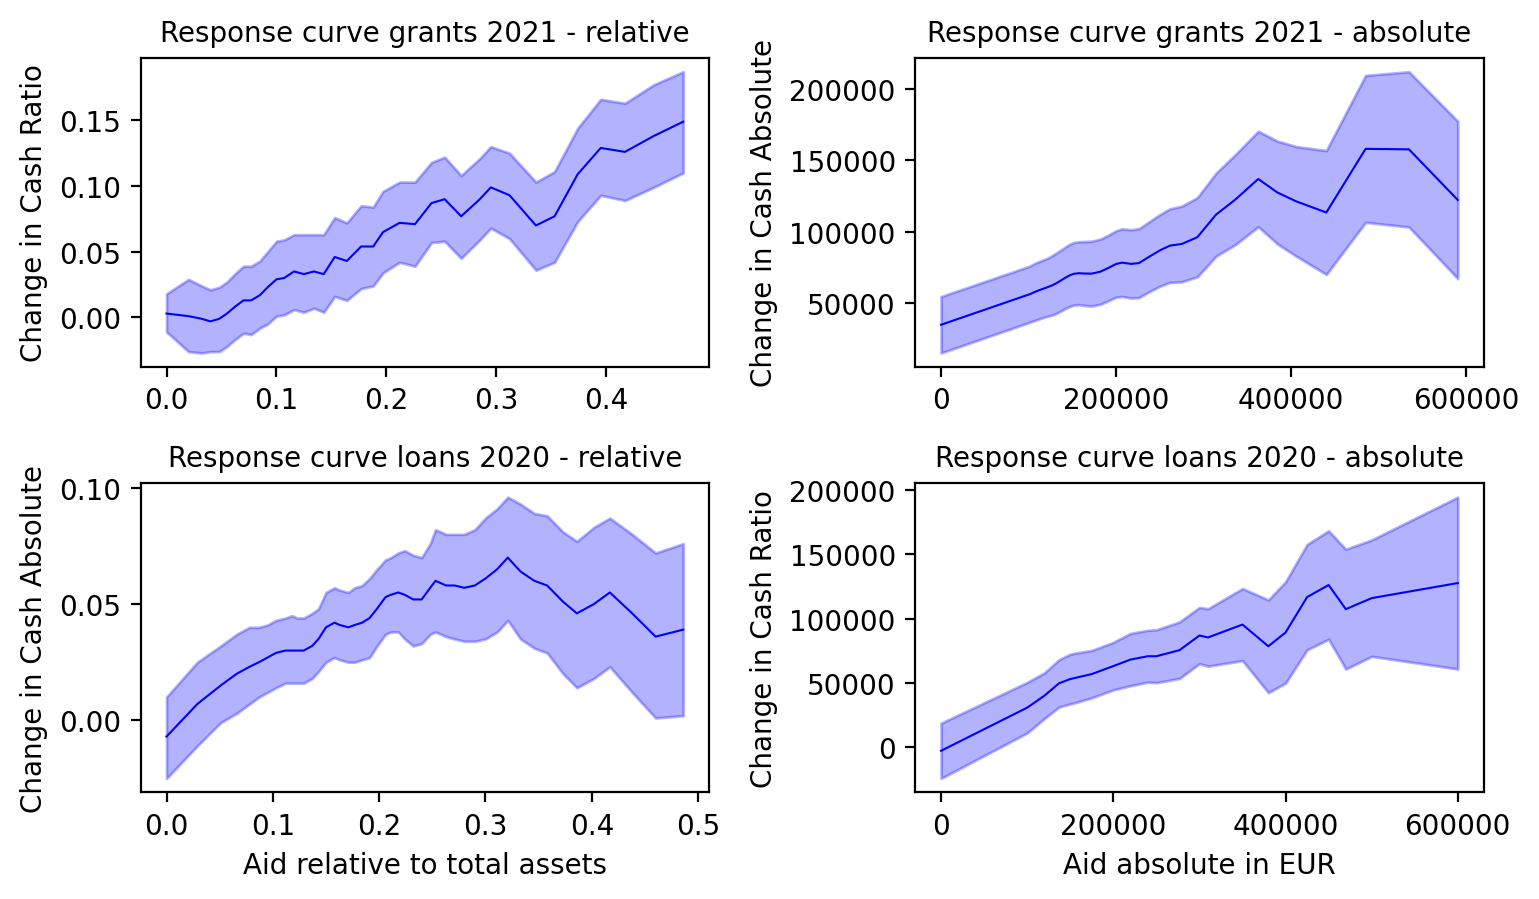

In [714]:
result_class = [['cash_ratio_grant', 'cash_abs_grant'], ['cash_ratio_loan', 'cash_abs_loan']]
result_name = [['Response curve grants 2021 - relative', 'Response curve grants 2021 - absolute'], ['Response curve loans 2020 - relative', 'Response curve loans 2020 - absolute']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('Change in Cash Absolute', fontsize = 10)
        axs[1,0].set_ylabel('Change in Cash Absolute', fontsize = 10)
        axs[1,1].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid absolute in EUR', fontsize = 10)

        axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)

        #axs[i,j].spines["top"].set_visible(False)
        #axs[i,j].spines["right"].set_visible(False)

        #axs[0,0].set_xlim(0, 0.45)
        #axs[1,0].set_xlim(0, 0.45)
        #axs[1,1].set_xlim(0, 589999)
        #axs[0,1].set_xlim(0, 589999)
        #axs[0,1].locator_params(nbins=3, axis='x')
        #axs[1,1].locator_params(nbins=3, axis='x')
        #axs[0,0].locator_params(nbins=3, axis='x')
        #axs[1,0].locator_params(nbins=3, axis='x')

        #axs[0,0].set_ylim(-0.02, 0.15)
        #axs[1,0].set_ylim(-0.02, 0.15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [715]:
fig.savefig('paper/Figures/causal_curves1_raw.png', bbox_inches='tight', dpi = 300)

### Solvency

In [716]:
potential_confounders_1=[]
potential_confounders_2=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)


# Try the model with cash_ratio / grants
potential_confounders_1 = potential_confounders + ['loan_relative_2021'] +['debt/asset_ratio_2020']
debtasset_grant_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
debtasset_grant_gps.fit(
    T=final_df['grant_relative_2021'], 
    X=final_df[potential_confounders_1], 
    y=final_df['delta_debt/asset_ratio_2021']
)
results_dict['debt/asset_ratio_grant'] = debtasset_grant_gps.calculate_CDRC(.95)


# Try the model with cash_ratio / loans
potential_confounders_2 = potential_confounders + ['grant_relative_2021'] +['debt/asset_ratio_2020']
debtasset_loan_gps = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
debtasset_loan_gps.fit(
    T=final_df['loan_relative_2021'], 
    X=final_df[potential_confounders_2], 
    y=final_df['delta_debt/asset_ratio_2021']
)
results_dict['debt/asset_ratio_loan'] = debtasset_loan_gps.calculate_CDRC(.95)


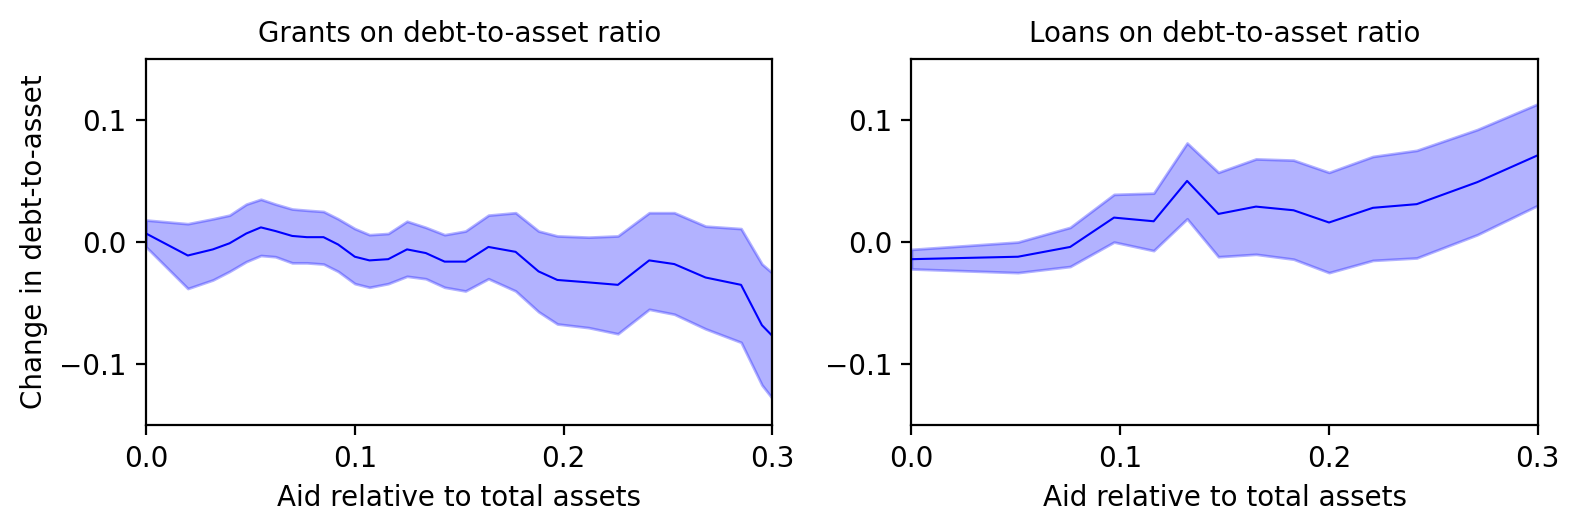

In [717]:
result_class = ['debt/asset_ratio_grant', 'debt/asset_ratio_loan']

result_name = ['Grants on debt-to-asset ratio', 'Loans on debt-to-asset ratio']

def plot_mean_and_CI(axs, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 3]

fig, axs = plt.subplots(1, 2)

i=0
for j in [0,1]:

    # Plotting quantities
    treat = results_dict[result_class[j]]['Treatment']
    mean = results_dict[result_class[j]]['Causal_Dose_Response']
    lb = results_dict[result_class[j]]['Lower_CI']
    ub = results_dict[result_class[j]]['Upper_CI']
    plot_mean_and_CI(axs, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

    # Labels
    axs[0].set_ylabel('Change in debt-to-asset', fontsize = 10)

    axs[0].set_xlabel('Aid relative to total assets', fontsize = 10)
    axs[1].set_xlabel('Aid relative to total assets', fontsize = 10)

    axs[0].set_xlim(0, 0.3)
    axs[0].set_ylim(-0.15, 0.15)
    axs[1].set_xlim(0, 0.3)
    axs[1].set_ylim(-0.15, 0.15)
    #axs[0,1].ticklabel_format(useOffset=False,style='plain')

    axs[j].set_title(result_name[j], fontsize = 10)
    axs[j].set_title(result_name[j], fontsize = 10)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    axs[0].locator_params(nbins=3, axis='x')
    axs[1].locator_params(nbins=3, axis='x')
    axs[0].locator_params(nbins=5, axis='y')
    axs[1].locator_params(nbins=5, axis='y')
    #axs[i,j].spines["top"].set_visible(False)
    #axs[i,j].spines["right"].set_visible(False)
    
    axs[j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

In [533]:
fig.savefig('paper/Figures/causal_curves2.png', bbox_inches='tight', dpi = 300)

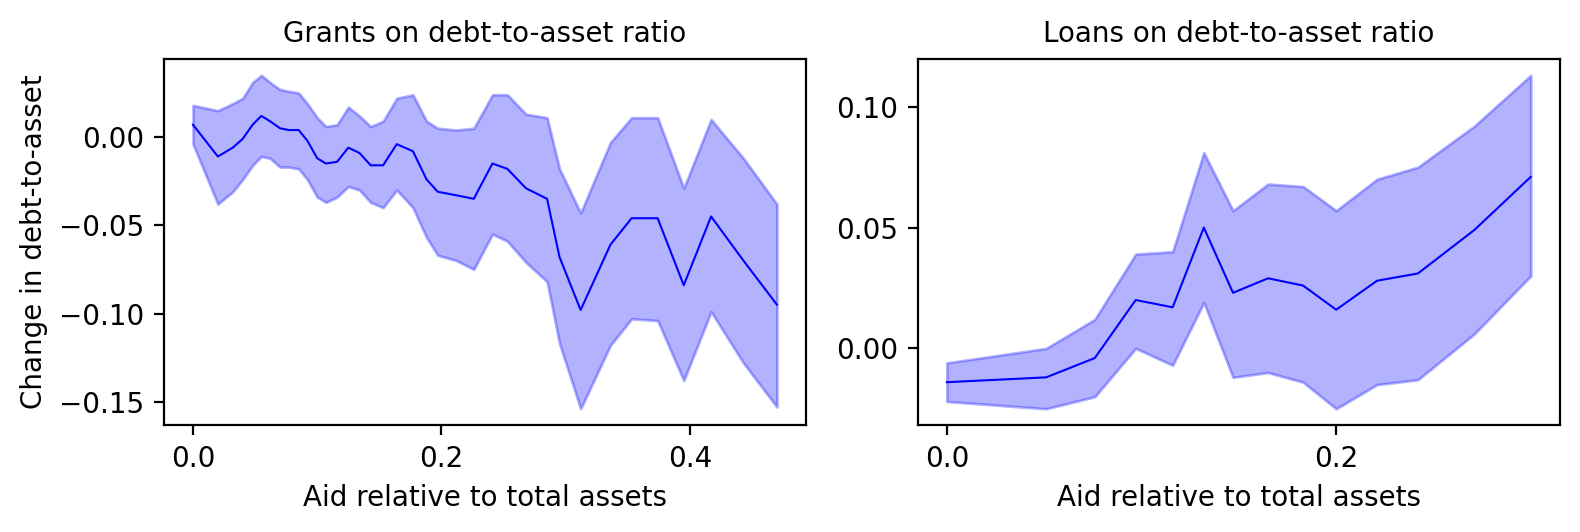

In [718]:
result_class = ['debt/asset_ratio_grant', 'debt/asset_ratio_loan']

result_name = ['Grants on debt-to-asset ratio', 'Loans on debt-to-asset ratio']

def plot_mean_and_CI(axs, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 3]

fig, axs = plt.subplots(1, 2)

i=0
for j in [0,1]:

    # Plotting quantities
    treat = results_dict[result_class[j]]['Treatment']
    mean = results_dict[result_class[j]]['Causal_Dose_Response']
    lb = results_dict[result_class[j]]['Lower_CI']
    ub = results_dict[result_class[j]]['Upper_CI']
    plot_mean_and_CI(axs, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

    # Labels
    axs[0].set_ylabel('Change in debt-to-asset', fontsize = 10)

    axs[0].set_xlabel('Aid relative to total assets', fontsize = 10)
    axs[1].set_xlabel('Aid relative to total assets', fontsize = 10)

    #axs[0].set_xlim(0, 0.3)
    #axs[0].set_ylim(-0.15, 0.15)
    #axs[1].set_xlim(0, 0.3)
    #axs[1].set_ylim(-0.15, 0.15)
    #axs[0,1].ticklabel_format(useOffset=False,style='plain')

    axs[j].set_title(result_name[j], fontsize = 10)
    axs[j].set_title(result_name[j], fontsize = 10)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    axs[0].locator_params(nbins=3, axis='x')
    axs[1].locator_params(nbins=3, axis='x')
    axs[0].locator_params(nbins=5, axis='y')
    axs[1].locator_params(nbins=5, axis='y')
    #axs[i,j].spines["top"].set_visible(False)
    #axs[i,j].spines["right"].set_visible(False)
    
    axs[j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

In [719]:
fig.savefig('paper/Figures/causal_curves2_raw.png', bbox_inches='tight', dpi = 300)

### Industries Size

#### Absolut cash in 2021 by grant

In [670]:
potential_confounders_1=[]
potential_confounders_2=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)


# Try the model with cash_ratio / grants
df_large = final_df[final_df['size'] == 'nur Großunternehmen' ]
potential_confounders_1 = ['debt/asset_ratio_2020']  
debtasset_grant_large = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_large.fit(
    T=df_large['aid_grant_2021'], 
    X=df_large[potential_confounders_1], 
    y=df_large['delta_cash_2021']
)
results_dict['asset_ratio_grant_large'] = debtasset_grant_large.calculate_CDRC(.95)


# Try the model with cash_ratio / loans
df_sme = final_df[final_df['size'] == 'Kleine und mittlere Unternehmen' ]
potential_confounders_2 = ['debt/asset_ratio_2020']
debtasset_grant_sme = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_sme.fit(
    T=df_sme['aid_grant_2021'], 
    X=df_sme[potential_confounders_2], 
    y=df_sme['delta_cash_2021']
)
results_dict['asset_ratio_grant_sme'] = debtasset_grant_sme.calculate_CDRC(.95)

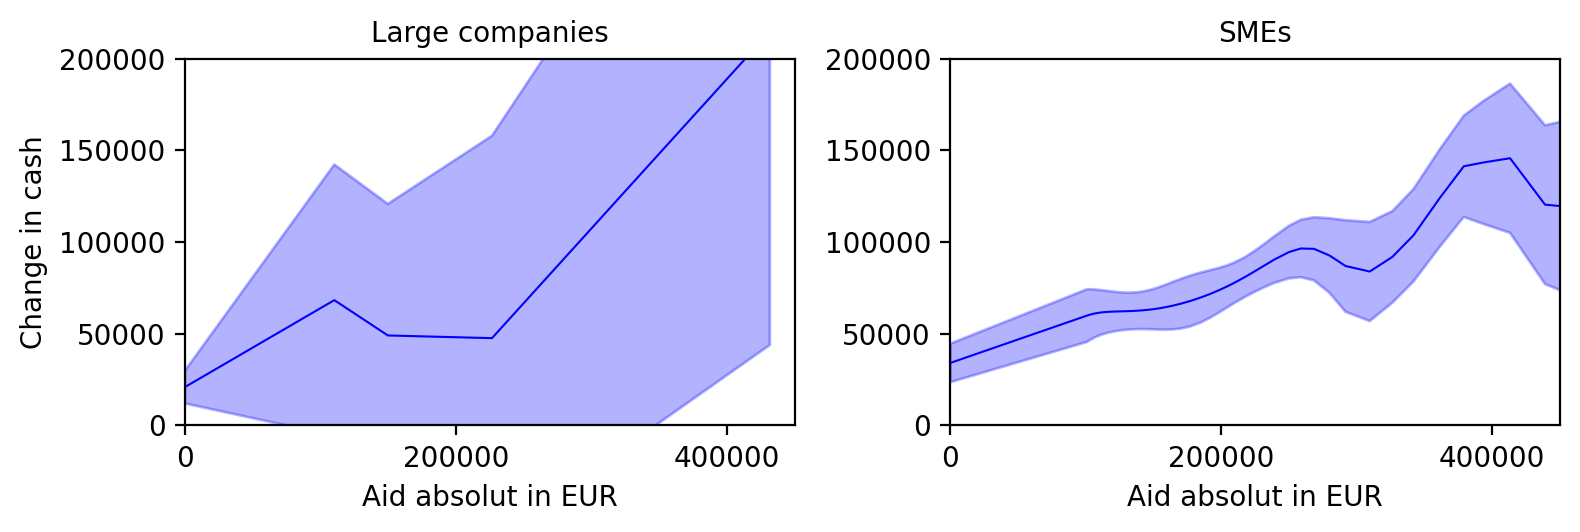

In [671]:
result_class = ['asset_ratio_grant_large', 'asset_ratio_grant_sme']

result_name = ['Large companies', 'SMEs']

def plot_mean_and_CI(axs, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 3]

fig, axs = plt.subplots(1, 2)

i=0
for j in [0,1]:

    # Plotting quantities
    treat = results_dict[result_class[j]]['Treatment']
    mean = results_dict[result_class[j]]['Causal_Dose_Response']
    lb = results_dict[result_class[j]]['Lower_CI']
    ub = results_dict[result_class[j]]['Upper_CI']
    plot_mean_and_CI(axs, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

    # Labels
    axs[0].set_ylabel('Change in cash', fontsize = 10)

    axs[0].set_xlabel('Aid absolut in EUR', fontsize = 10)
    axs[1].set_xlabel('Aid absolut in EUR', fontsize = 10)

    axs[0].set_xlim(0, 450000)
    axs[0].set_ylim(0, 200000)
    axs[1].set_xlim(0,450000)
    axs[1].set_ylim(0, 200000)
    #axs[0,1].ticklabel_format(useOffset=False,style='plain')

    axs[j].set_title(result_name[j], fontsize = 10)
    axs[j].set_title(result_name[j], fontsize = 10)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    axs[0].locator_params(nbins=3, axis='x')
    axs[1].locator_params(nbins=3, axis='x')
    axs[0].locator_params(nbins=5, axis='y')
    axs[1].locator_params(nbins=5, axis='y')
    #axs[i,j].spines["top"].set_visible(False)
    #axs[i,j].spines["right"].set_visible(False)
    
    axs[j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

#### relative cash in 2020 by loan

In [672]:
potential_confounders_1=[]
potential_confounders_2=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)


# Try the model with cash_ratio / grants
df_large = final_df[final_df['size'] == 'nur Großunternehmen' ]
potential_confounders_1 = ['days_loan_2020'] #+ ['aid_loan_2020']
debtasset_grant_large = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_large.fit(
    T=df_large['loan_relative_2020'], 
    X=df_large[potential_confounders_1], 
    y=df_large['delta_cash_ratio_2020']
)
results_dict['asset_ratio_grant_large'] = debtasset_grant_large.calculate_CDRC(.95)


# Try the model with cash_ratio / loans
df_sme = final_df[final_df['size'] == 'Kleine und mittlere Unternehmen' ]
potential_confounders_2 = ['days_loan_2020']#+ ['aid_loan_2020']
debtasset_grant_sme = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_sme.fit(
    T=df_sme['loan_relative_2020'], 
    X=df_sme[potential_confounders_2], 
    y=df_sme['delta_cash_ratio_2020']
)
results_dict['asset_ratio_grant_sme'] = debtasset_grant_sme.calculate_CDRC(.95)

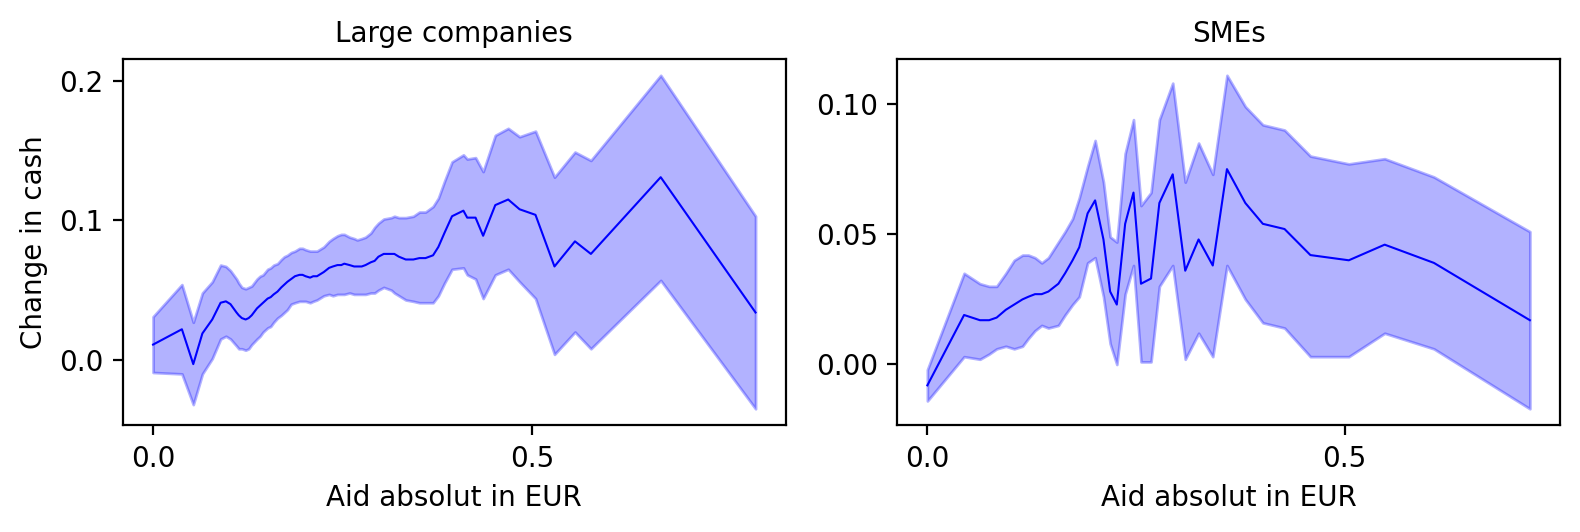

In [673]:
result_class = ['asset_ratio_grant_large', 'asset_ratio_grant_sme']

result_name = ['Large companies', 'SMEs']

def plot_mean_and_CI(axs, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 3]

fig, axs = plt.subplots(1, 2)

i=0
for j in [0,1]:

    # Plotting quantities
    treat = results_dict[result_class[j]]['Treatment']
    mean = results_dict[result_class[j]]['Causal_Dose_Response']
    lb = results_dict[result_class[j]]['Lower_CI']
    ub = results_dict[result_class[j]]['Upper_CI']
    plot_mean_and_CI(axs, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

    # Labels
    axs[0].set_ylabel('Change in cash', fontsize = 10)

    axs[0].set_xlabel('Aid absolut in EUR', fontsize = 10)
    axs[1].set_xlabel('Aid absolut in EUR', fontsize = 10)

    #axs[0].set_xlim(0, 450000)
    #axs[0].set_ylim(0, 200000)
    #axs[1].set_xlim(0,450000)
    #axs[1].set_ylim(0, 200000)
    #axs[0,1].ticklabel_format(useOffset=False,style='plain')

    axs[j].set_title(result_name[j], fontsize = 10)
    axs[j].set_title(result_name[j], fontsize = 10)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    axs[0].locator_params(nbins=3, axis='x')
    axs[1].locator_params(nbins=3, axis='x')
    axs[0].locator_params(nbins=5, axis='y')
    axs[1].locator_params(nbins=5, axis='y')
    #axs[i,j].spines["top"].set_visible(False)
    #axs[i,j].spines["right"].set_visible(False)
    
    axs[j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

#### absolut debt ratio in 2020 by loan

In [695]:
potential_confounders_1=[]
potential_confounders_2=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)


# Try the model with cash_ratio / grants
df_large = final_df[final_df['size'] == 'nur Großunternehmen' ]
potential_confounders_1 = ['days_loan_2020'] #+ ['aid_loan_2020']
debtasset_grant_large = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_large.fit(
    T=df_large['aid_loan_2020'], 
    X=df_large[potential_confounders_1], 
    y=df_large['delta_debt/asset_ratio_2020']
)
results_dict['asset_ratio_grant_large'] = debtasset_grant_large.calculate_CDRC(.95)


# Try the model with cash_ratio / loans
df_sme = final_df[final_df['size'] == 'Kleine und mittlere Unternehmen' ]
potential_confounders_2 = ['days_loan_2020']#+ ['aid_loan_2020']
debtasset_grant_sme = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.99)
debtasset_grant_sme.fit(
    T=df_sme['aid_loan_2020'], 
    X=df_sme[potential_confounders_2], 
    y=df_sme['delta_debt/asset_ratio_2020']
)
results_dict['asset_ratio_grant_sme'] = debtasset_grant_sme.calculate_CDRC(.95)

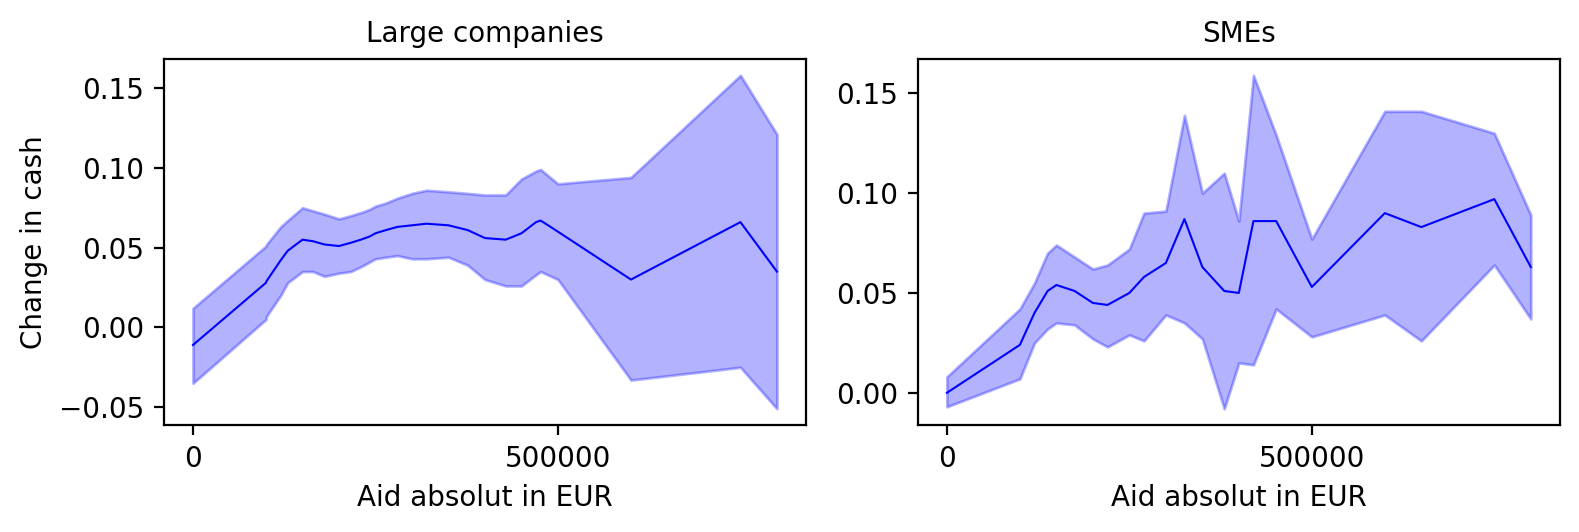

In [696]:
result_class = ['asset_ratio_grant_large', 'asset_ratio_grant_sme']

result_name = ['Large companies', 'SMEs']

def plot_mean_and_CI(axs, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 3]

fig, axs = plt.subplots(1, 2)

i=0
for j in [0,1]:

    # Plotting quantities
    treat = results_dict[result_class[j]]['Treatment']
    mean = results_dict[result_class[j]]['Causal_Dose_Response']
    lb = results_dict[result_class[j]]['Lower_CI']
    ub = results_dict[result_class[j]]['Upper_CI']
    plot_mean_and_CI(axs, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

    # Labels
    axs[0].set_ylabel('Change in cash', fontsize = 10)

    axs[0].set_xlabel('Aid absolut in EUR', fontsize = 10)
    axs[1].set_xlabel('Aid absolut in EUR', fontsize = 10)

    #axs[0].set_xlim(0, 450000)
    #axs[0].set_ylim(0, 200000)
    #axs[1].set_xlim(0,450000)
    #axs[1].set_ylim(0, 200000)
    #axs[0,1].ticklabel_format(useOffset=False,style='plain')

    axs[j].set_title(result_name[j], fontsize = 10)
    axs[j].set_title(result_name[j], fontsize = 10)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    #axs[i,j].set_title(result_name[i][j], fontsize = 8)
    axs[0].locator_params(nbins=3, axis='x')
    axs[1].locator_params(nbins=3, axis='x')
    axs[0].locator_params(nbins=5, axis='y')
    axs[1].locator_params(nbins=5, axis='y')
    #axs[i,j].spines["top"].set_visible(False)
    #axs[i,j].spines["right"].set_visible(False)
    
    axs[j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)

### Industries

In [720]:
nace_eng = pd.read_csv('NACE_ENG.csv',encoding='utf-8-sig', delimiter=',',usecols = ['Code','Description'])
nace_eng.at[0,'Code'] = '01'
nace_eng['Code'] = nace_eng['Code'].astype(str)

In [721]:
final_df = final_df.merge(nace_eng, 
                how='left', 
                left_on='industry', 
                right_on='Code')

In [722]:
potential_confounders_1=[]
potential_confounders_2=[]
potential_confounders_3=[]
potential_confounders_4=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)

# Potential confounders
potential_confounders_1 = potential_confounders + ['loan_relative_2021'] + ['days_grant_2021'] + ['debt/asset_ratio_2020']

# Try the model with cash_ratio / grants for Food and beverage service activities

df_gastro = final_df[final_df.Code == '56' ]
cash_ratio_grant_gps_gastro = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_grant_gps_gastro.fit(
    T=df_gastro['grant_relative_2021'], 
    X=df_gastro[potential_confounders_1], 
    y=df_gastro['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_gastro'] = cash_ratio_grant_gps_gastro.calculate_CDRC(.95)



# Try the model with cash_ratio / grants for Travel agency, tour operator and other
df_travel = final_df[final_df.Code == '79' ]
cash_ratio_loan_gps_travel = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_loan_gps_travel.fit(
    T=df_travel['grant_relative_2021'], 
    X=df_travel[potential_confounders_1], 
    y=df_travel['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_travel'] = cash_ratio_loan_gps_travel.calculate_CDRC(.95)

# Try the model with cash absolut / grants

df_creative = final_df[final_df.Code == '90' ]
cash_ratio_grant_gps_creative = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95,gps_family = "lognormal")
cash_ratio_grant_gps_creative.fit(
    T=df_creative['grant_relative_2021'], 
    X=df_creative[potential_confounders_1], 
    y=df_creative['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_creative'] = cash_ratio_grant_gps_creative.calculate_CDRC(.95)



# Try the model with cash absolut / loans

df_creative = final_df[final_df.Code == '93' ]
cash_ratio_grant_gps_sports = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95,gps_family = "lognormal")
cash_ratio_grant_gps_sports.fit(
    T=df_creative['grant_relative_2021'], 
    X=df_creative[potential_confounders_1], 
    y=df_creative['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_sports'] = cash_ratio_grant_gps_sports.calculate_CDRC(.95)

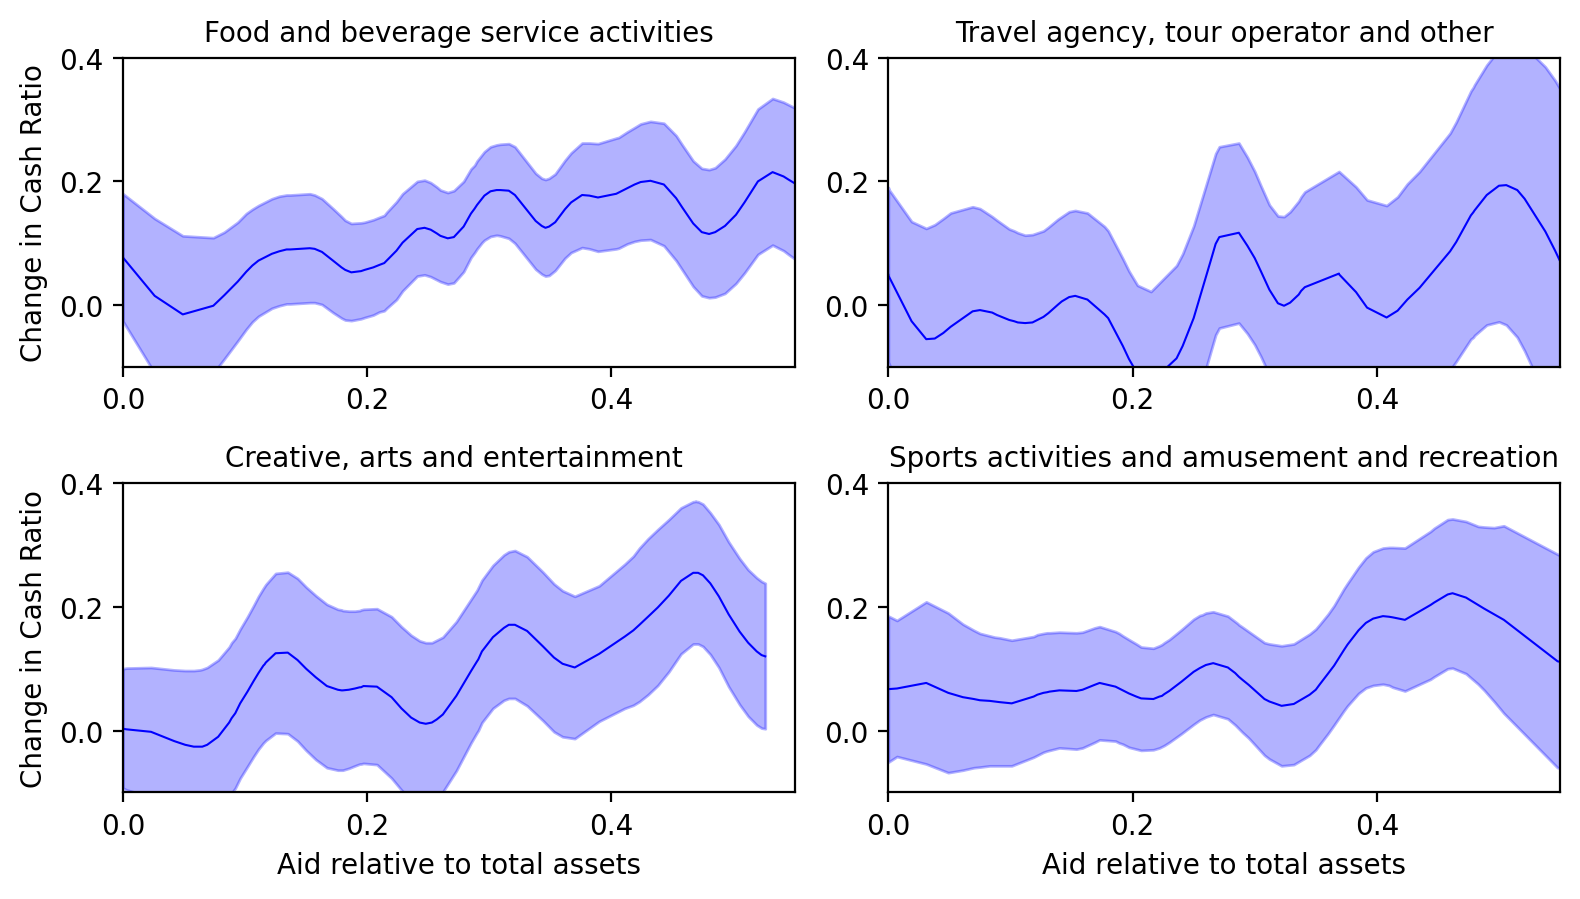

In [723]:
result_class = [['cash_ratio_grant_gastro', 'cash_ratio_grant_travel'], ['cash_ratio_grant_creative', 'cash_ratio_grant_sports']]
result_name = [['Food and beverage service activities', 'Travel agency, tour operator and other'], ['Creative, arts and entertainment ', 'Sports activities and amusement and recreation']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 10)

        axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)

        axs[i,j].set_ylim(-0.1, 0.4)
        axs[i,j].set_xlim(0, 0.55)
        
        axs[i,j].locator_params(nbins=3, axis='x')
        axs[i,j].locator_params(nbins=3, axis='y')

        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [558]:
fig.savefig('paper/Figures/causal_curves_industries1.png', bbox_inches='tight', dpi = 300)

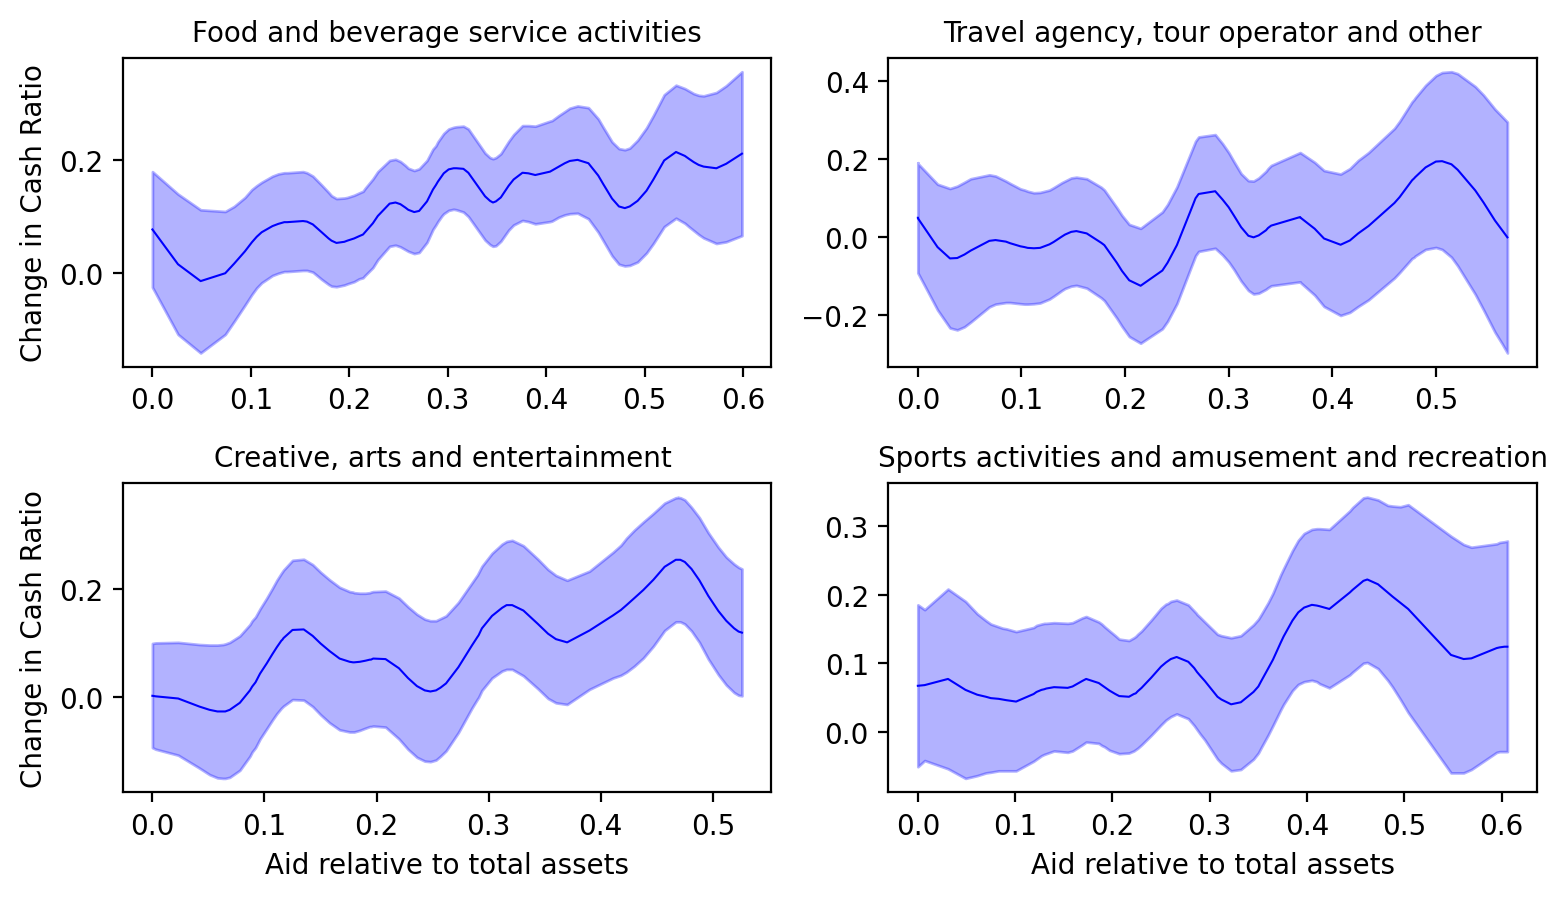

In [727]:
result_class = [['cash_ratio_grant_gastro', 'cash_ratio_grant_travel'], ['cash_ratio_grant_creative', 'cash_ratio_grant_sports']]
result_name = [['Food and beverage service activities', 'Travel agency, tour operator and other'], ['Creative, arts and entertainment ', 'Sports activities and amusement and recreation']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 10)

        #axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)

        #axs[i,j].set_ylim(-0.1, 0.4)
        #axs[i,j].set_xlim(0, 0.55)
        
        #axs[i,j].locator_params(nbins=3, axis='x')
        #axs[i,j].locator_params(nbins=3, axis='y')

        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [728]:
fig.savefig('paper/Figures/causal_curves_industries1_RAW.png', bbox_inches='tight', dpi = 300)

In [729]:
potential_confounders_1=[]
potential_confounders_2=[]
potential_confounders_3=[]
potential_confounders_4=[]
# Dictionary to store model results
results_dict = {}

potential_confounders = list(condounders.columns)

# Potential confounders
potential_confounders_1 = potential_confounders + ['loan_relative_2021'] + ['days_grant_2021'] + ['debt/asset_ratio_2020']

# Try the model with cash_ratio / grants for Food and beverage service activities

df_accomondation = final_df[final_df.Code == '55' ]
cash_ratio_grant_gps_accomondation = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_grant_gps_accomondation.fit(
    T=df_accomondation['grant_relative_2021'], 
    X=df_accomondation[potential_confounders_1], 
    y=df_accomondation['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_accomondation'] = cash_ratio_grant_gps_accomondation.calculate_CDRC(.95)



# Try the model with cash_ratio / grants for Travel agency, tour operator and other
df_wholesale = final_df[final_df.Code == '46' ]
cash_ratio_loan_gps_wholesale = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_loan_gps_wholesale.fit(
    T=df_wholesale['grant_relative_2021'], 
    X=df_wholesale[potential_confounders_1], 
    y=df_wholesale['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_wholesale'] = cash_ratio_loan_gps_wholesale.calculate_CDRC(.95)

# Try the model with cash absolut / grants

df_construction = final_df[final_df.Code == '82' ]
cash_ratio_grant_gps_construction = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_grant_gps_construction.fit(
    T=df_construction['grant_relative_2021'], 
    X=df_construction[potential_confounders_1], 
    y=df_construction['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_construction'] = cash_ratio_grant_gps_construction.calculate_CDRC(.95)



# Try the model with cash absolut / loans

df_retail = final_df[final_df.Code == '47' ]
cash_ratio_grant_gps_retail = GPS_Regressor(treatment_grid_num=100 ,random_seed=111, upper_grid_constraint= 0.95)
cash_ratio_grant_gps_retail.fit(
    T=df_retail['grant_relative_2021'], 
    X=df_retail[potential_confounders_1], 
    y=df_retail['delta_cash_ratio_2021']
)
results_dict['cash_ratio_grant_retail'] = cash_ratio_grant_gps_retail.calculate_CDRC(.95)

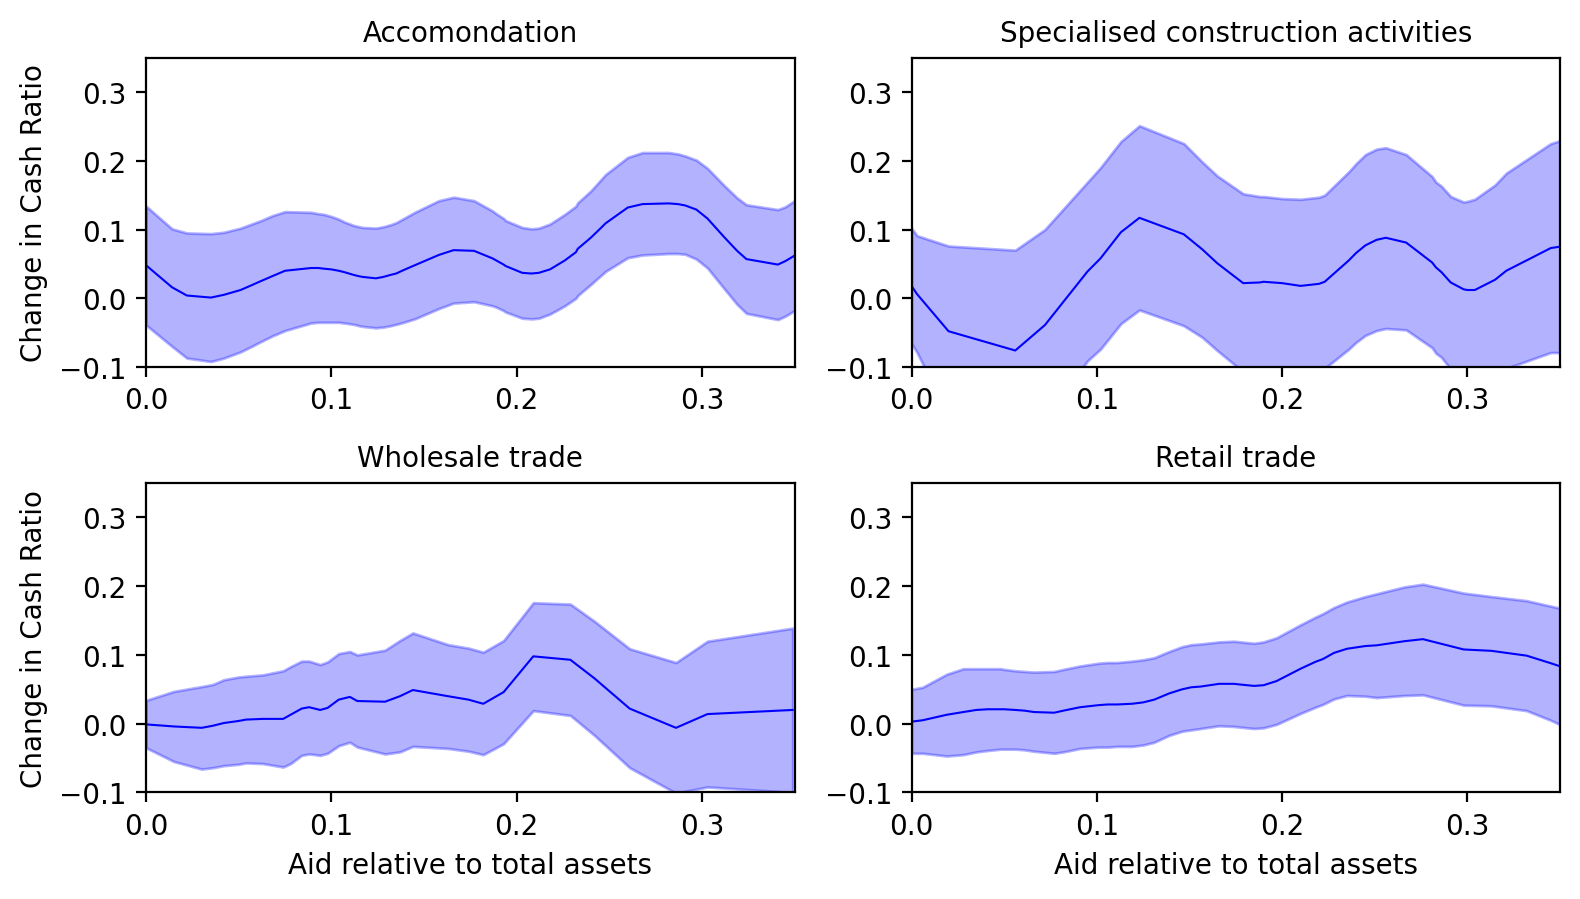

In [730]:
result_class = [['cash_ratio_grant_accomondation', 'cash_ratio_grant_construction'], ['cash_ratio_grant_wholesale', 'cash_ratio_grant_retail']]
result_name = [['Accomondation', 'Specialised construction activities'], ['Wholesale trade', 'Retail trade']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 10)

        axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)


        axs[i,j].set_ylim(-0.1, 0.35)
        axs[i,j].set_xlim(0, 0.35)

        axs[i,j].locator_params(nbins=4, axis='x')
        axs[i,j].locator_params(nbins=5, axis='y')
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [566]:
fig.savefig('paper/Figures/causal_curves_industries2.png', bbox_inches='tight', dpi = 300)

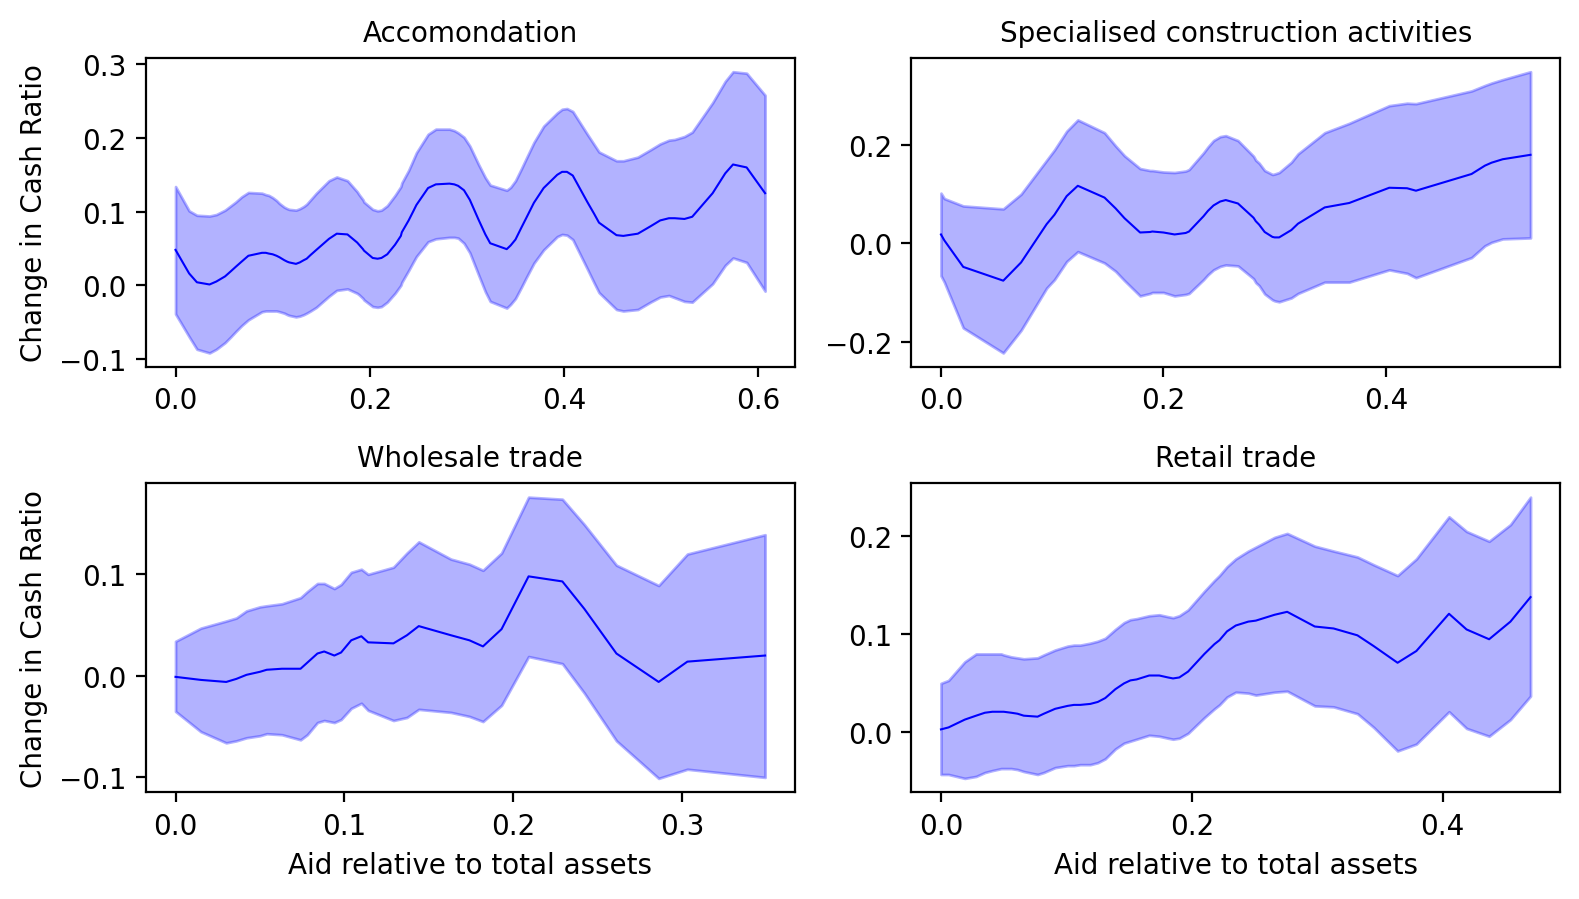

In [731]:
result_class = [['cash_ratio_grant_accomondation', 'cash_ratio_grant_construction'], ['cash_ratio_grant_wholesale', 'cash_ratio_grant_retail']]
result_name = [['Accomondation', 'Specialised construction activities'], ['Wholesale trade', 'Retail trade']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [8, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Change in Cash Ratio', fontsize = 10)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 10)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 10)

        axs[0,1].ticklabel_format(useOffset=False,style='plain')

        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)
        axs[i,j].set_title(result_name[i][j], fontsize = 10)


        #axs[i,j].set_ylim(-0.1, 0.35)
        #axs[i,j].set_xlim(0, 0.35)

        axs[i,j].locator_params(nbins=4, axis='x')
        axs[i,j].locator_params(nbins=5, axis='y')
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [732]:
fig.savefig('paper/Figures/causal_curves_industries2_raw.png', bbox_inches='tight', dpi = 300)

### Further exploration

In [ ]:
final_df[final_df['delta_cash_2021'].between(*final_df['delta_cash_2021'].quantile([0.01, 0.99]).tolist())]


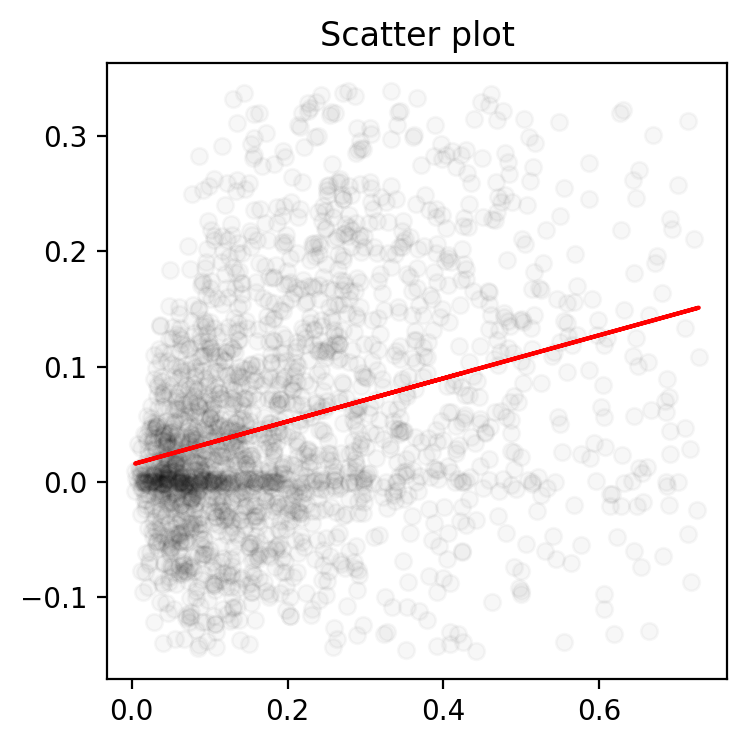

In [356]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.scatter(final_df[['aid_relative_2021']],final_df[['delta_cash_ratio_2021']],  alpha=.03, color='k')
plt.title('Scatter plot')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(final_df['aid_relative_2021'],final_df['delta_cash_ratio_2021'], deg = 1)
#use red as color for regression line
plt.plot(final_df['aid_relative_2021'], m*final_df['aid_relative_2021']+b, color='red')

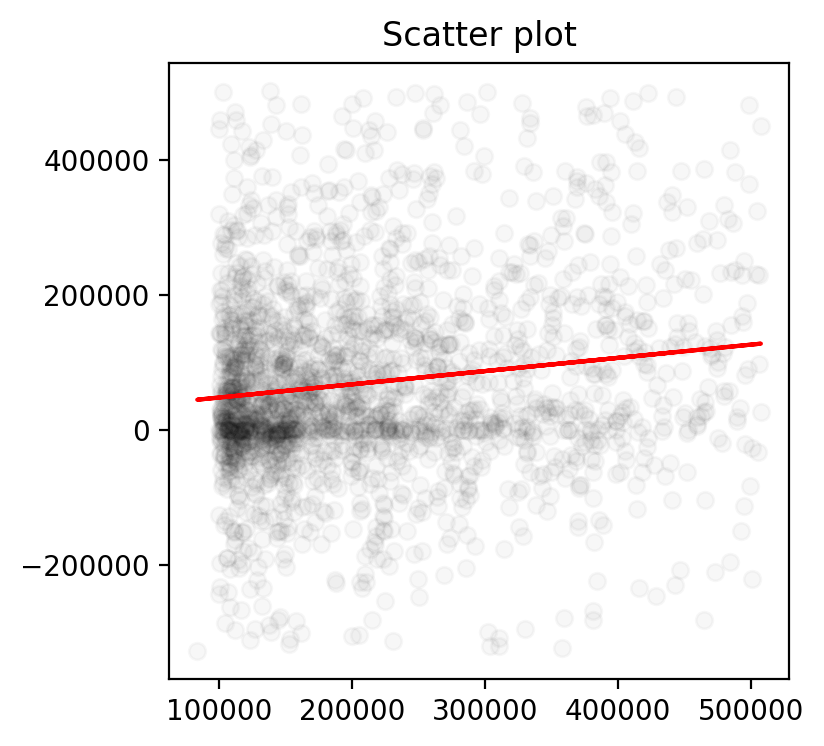

In [357]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.scatter(final_df[['grant_2021']],final_df[['delta_cash_2021']],  alpha=.03, color='k')
plt.title('Scatter plot')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(final_df['grant_2021'],final_df['delta_cash_2021'], deg = 1)
#use red as color for regression line
plt.plot(final_df['grant_2021'], m*final_df['grant_2021']+b, color='red')

In [61]:
np.polyfit(final_df['aid_relative_2021'],final_df['delta_cash_ratio_2021'], 1)

array([ 0.26475814, -0.00128937])

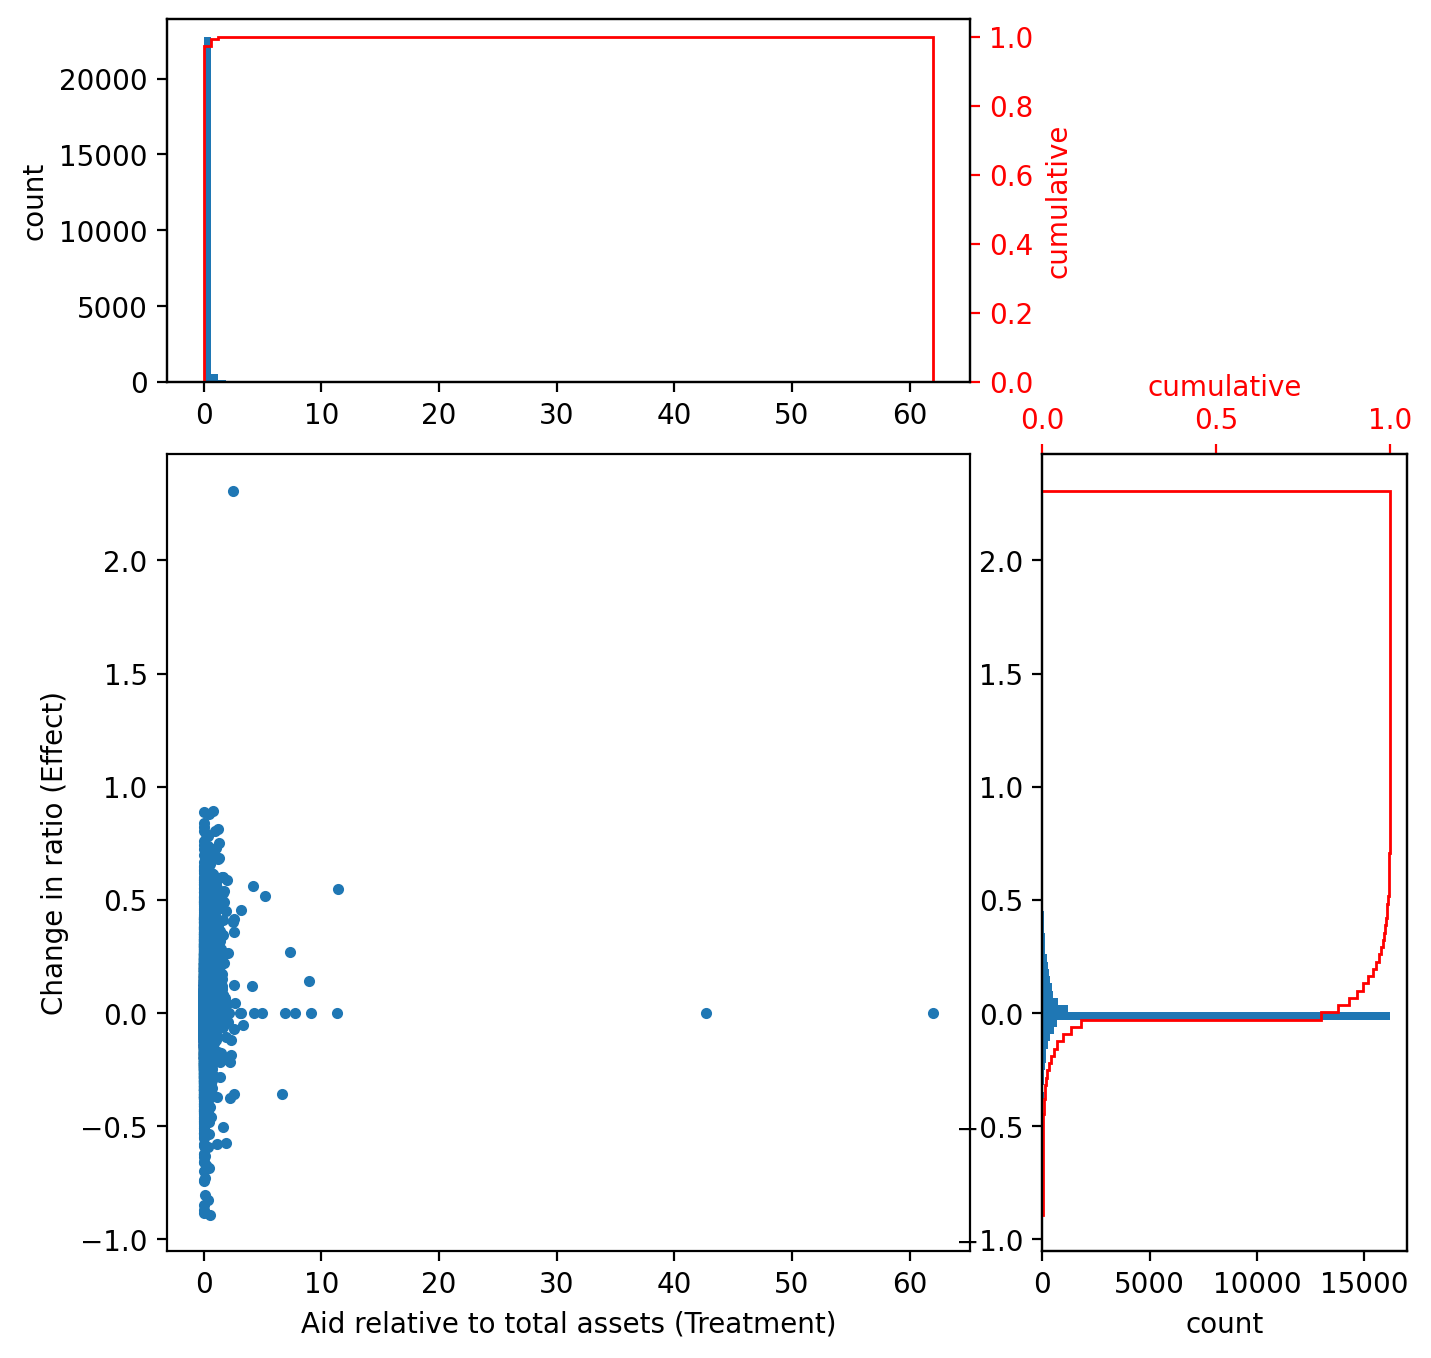

In [169]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = final_df[['grant_relative_2021']]
y = final_df[['delta_cash_ratio_2021']]

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(x,y,marker='.')
ax_main.set(xlabel="Aid relative to total assets (Treatment)", ylabel="Change in ratio (Effect)")

ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')

plt.show()

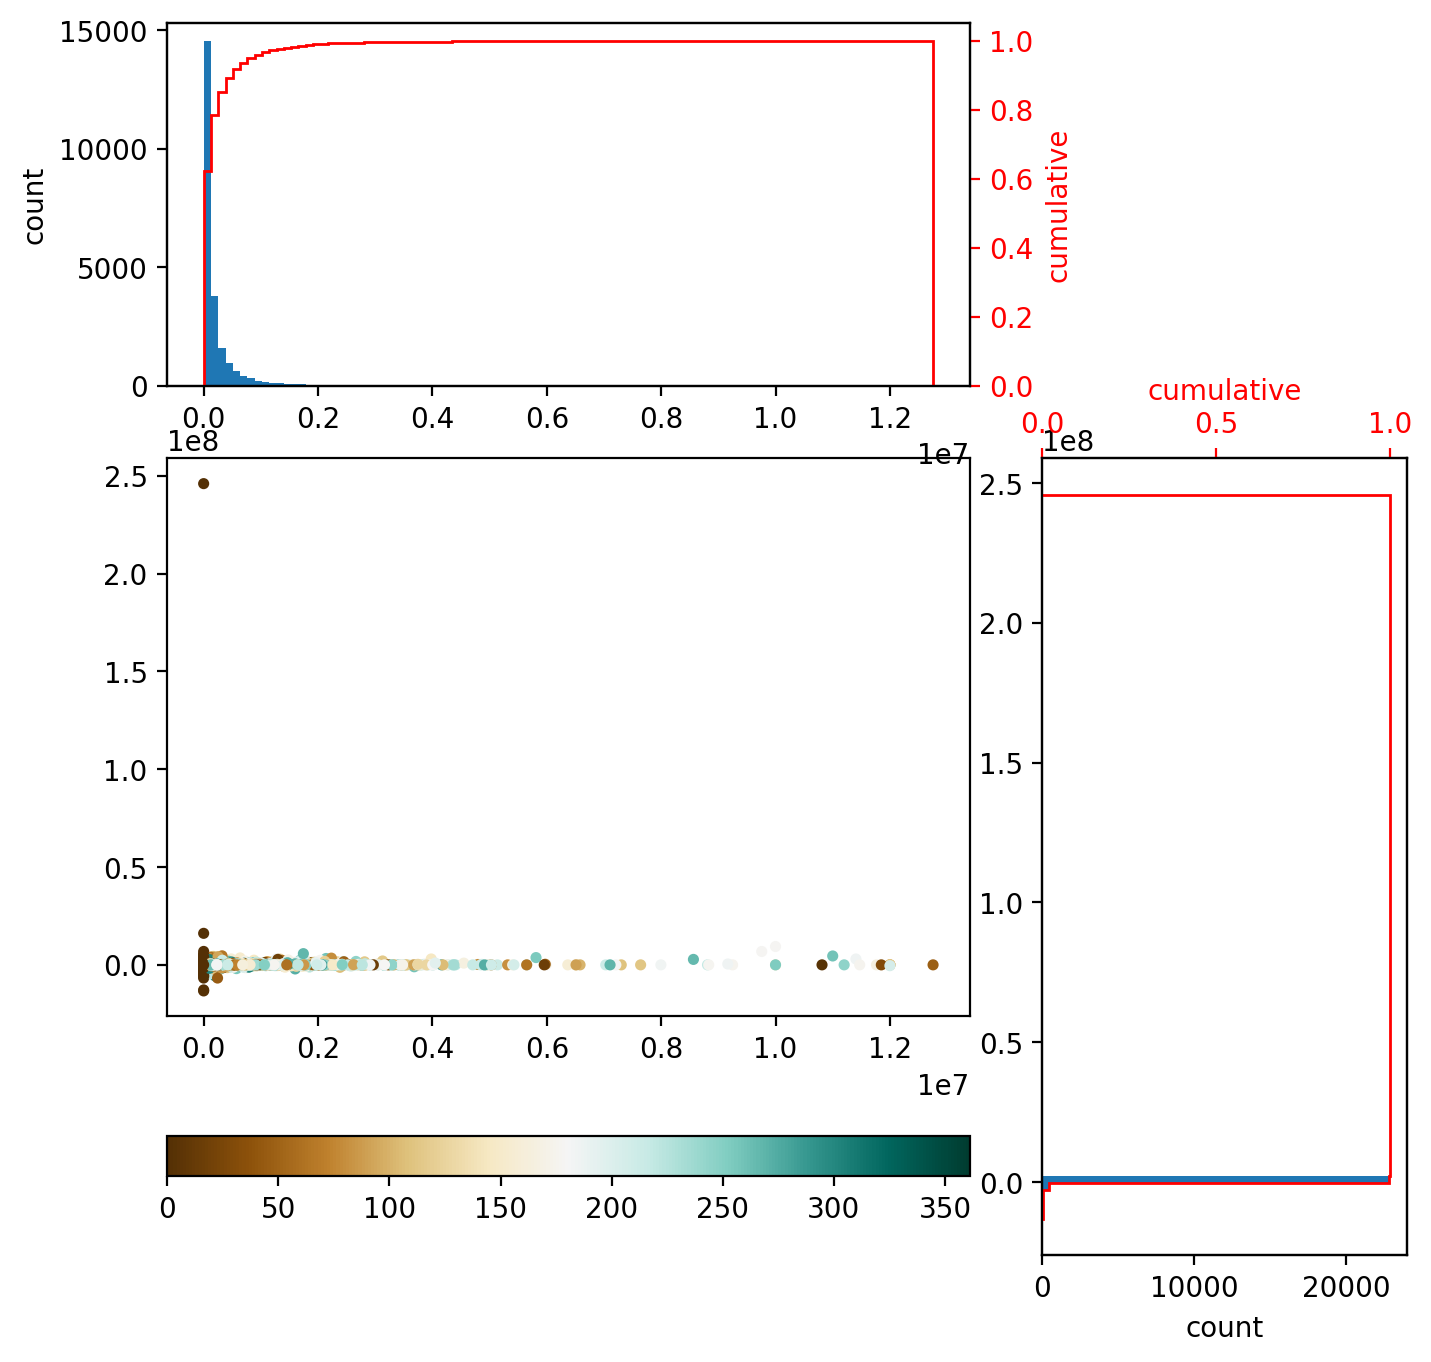

In [171]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib as mpl
import numpy as np

x = final_df[['aid_grant_2021']]
y = final_df[['delta_cash_2021']]
z = final_df['days_grant_2021']

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])

#ax_bar = plt.subplot(gs[1:3, :4])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
#ax_main.scatter(x,y,c=z,marker='.',cmap="BrBG")
#ax_main.set(xlabel="Aid (Treatment)", ylabel="Change in cash (Effect)")

# colorbar
sctr = ax_main.scatter(x,y,c=z,marker='.',cmap="BrBG")
plt.colorbar(sctr, ax=ax_main, location='bottom')#, format='$%d')
#ax_main.set_yscale('log')


ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')


plt.show()

#### 2020 grants

##### current ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()
data_dd = data_dd.drop(data_dd[data_dd['current_ratio_2019'] > data_dd['current_ratio_2019'].quantile(.95)].index)


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     61.79
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.09e-39
Time:                        17:14:45   Log-Likelihood:                -27326.
No. Observations:               14403   AIC:                         5.466e+04
Df Residuals:                   14399   BIC:                         5.469e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7441      0.020     

##### quick ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     59.80
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.98e-38
Time:                        14:44:36   Log-Likelihood:                -33515.
No. Observations:               15704   AIC:                         6.704e+04
Df Residuals:                   15700   BIC:                         6.707e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5910      0.024     

##### cash ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)


from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.85
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           2.16e-15
Time:                        16:06:55   Log-Likelihood:                 6280.1
No. Observations:               15167   AIC:                        -1.255e+04
Df Residuals:                   15163   BIC:                        -1.252e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1618      0.002     

##### debt to equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.635
Date:                Tue, 18 Apr 2023   Prob (F-statistic):              0.179
Time:                        14:39:21   Log-Likelihood:                -37471.
No. Observations:               13022   AIC:                         7.495e+04
Df Residuals:                   13018   BIC:                         7.498e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.9009      0.056     

##### debt to asset ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.963
Date:                Tue, 18 Apr 2023   Prob (F-statistic):             0.0308
Time:                        14:41:15   Log-Likelihood:                -3560.9
No. Observations:               16949   AIC:                             7130.
Df Residuals:                   16945   BIC:                             7161.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['loan_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','grant_2020']]
data_dd['treatment_group'] = np.where(data_dd['grant_2020'].isna() , 0, 1)
data_dd = data_dd.drop('grant_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.357
Date:                Tue, 18 Apr 2023   Prob (F-statistic):            0.00110
Time:                        15:55:02   Log-Likelihood:                -968.33
No. Observations:               14730   AIC:                             1945.
Df Residuals:                   14726   BIC:                             1975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3735      0.003    1

#### 2020 loans

##### current ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['current_ratio_2019','current_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()
data_dd = data_dd.drop(data_dd[data_dd['current_ratio_2019'] > data_dd['current_ratio_2019'].quantile(.95)].index)


# data before the treatment
df_before = data_dd[['current_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['current_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['current_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['current_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['current_ratio'] > df_reg['current_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['current_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('current_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          current_ratio   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     180.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.60e-115
Time:                        15:25:25   Log-Likelihood:                -40940.
No. Observations:               24022   AIC:                         8.189e+04
Df Residuals:                   24018   BIC:                         8.192e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.6362      0.017     

##### quick ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['qick_ratio_2019','qick_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['qick_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['qick_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['qick_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['qick_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['qick_ratio'] > df_reg['qick_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('qick_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             qick_ratio   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     210.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          9.63e-135
Time:                        15:25:13   Log-Likelihood:                -50471.
No. Observations:               26186   AIC:                         1.010e+05
Df Residuals:                   26182   BIC:                         1.010e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4609      0.020     

##### cash ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['cash_ratio_2019','cash_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['cash_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['cash_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['cash_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['cash_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg[df_reg['cash_ratio'] > 0 ] # 0 values are not plausable
df_reg = df_reg.drop(df_reg[df_reg['cash_ratio'] > df_reg['cash_ratio'].quantile(.95)].index)

from statsmodels.formula.api import ols
ols = ols('cash_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cash_ratio   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.25e-141
Time:                        16:07:15   Log-Likelihood:                 13375.
No. Observations:               25284   AIC:                        -2.674e+04
Df Residuals:                   25280   BIC:                        -2.671e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1517      0.002     

##### debt to equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2equity_ratio_2019','debt2equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2equity_ratio'] > df_reg['debt2equity_ratio'].quantile(.95)].index)
df_reg = df_reg[df_reg['debt2equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      debt2equity_ratio   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     169.7
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          9.09e-109
Time:                        15:24:47   Log-Likelihood:                -66317.
No. Observations:               22111   AIC:                         1.326e+05
Df Residuals:                   22107   BIC:                         1.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0230      0.063     

##### debt to asset ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['debt2asset_ratio_2019','debt2asset_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['debt2asset_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['debt2asset_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['debt2asset_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['debt2asset_ratio'] > df_reg['debt2asset_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['debt2asset_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('debt2asset_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:       debt2asset_ratio   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     422.3
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          2.19e-268
Time:                        15:23:56   Log-Likelihood:                -3290.4
No. Observations:               28308   AIC:                             6589.
Df Residuals:                   28304   BIC:                             6622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5591      0.003    1

##### equity ratio

In [ ]:
# Remove companies that received loans in 2020 due to possible confunding
data_dd = merged_df[merged_df['grant_2020'].isnull()]
data_dd = data_dd[['equity_ratio_2019','equity_ratio_2020','loan_2020']]
data_dd['treatment_group'] = np.where(data_dd['loan_2020'].isna() , 0, 1)
data_dd = data_dd.drop('loan_2020', axis=1)
data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
data_dd = data_dd.dropna()

# data before the treatment
df_before = data_dd[['equity_ratio_2019', 'treatment_group']]
df_before['t'] = 0
df_before.columns = ['equity_ratio', 'treatment_group', 'time']

# data after the treatment
df_after = data_dd[['equity_ratio_2020', 'treatment_group']]
df_after['t'] = 1
df_after.columns = ['equity_ratio', 'treatment_group', 'time']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['interaction'] = df_reg.treatment_group * df_reg.time

# drop extrem outliers
df_reg = df_reg.drop(df_reg[df_reg['equity_ratio'] > df_reg['equity_ratio'].quantile(.999)].index)
df_reg = df_reg[df_reg['equity_ratio'] > 0 ]

from statsmodels.formula.api import ols
ols = ols('equity_ratio ~ treatment_group + time + interaction', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           equity_ratio   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     485.3
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          1.55e-306
Time:                        15:23:48   Log-Likelihood:                 1060.8
No. Observations:               25056   AIC:                            -2114.
Df Residuals:                   25052   BIC:                            -2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3727      0.003    1

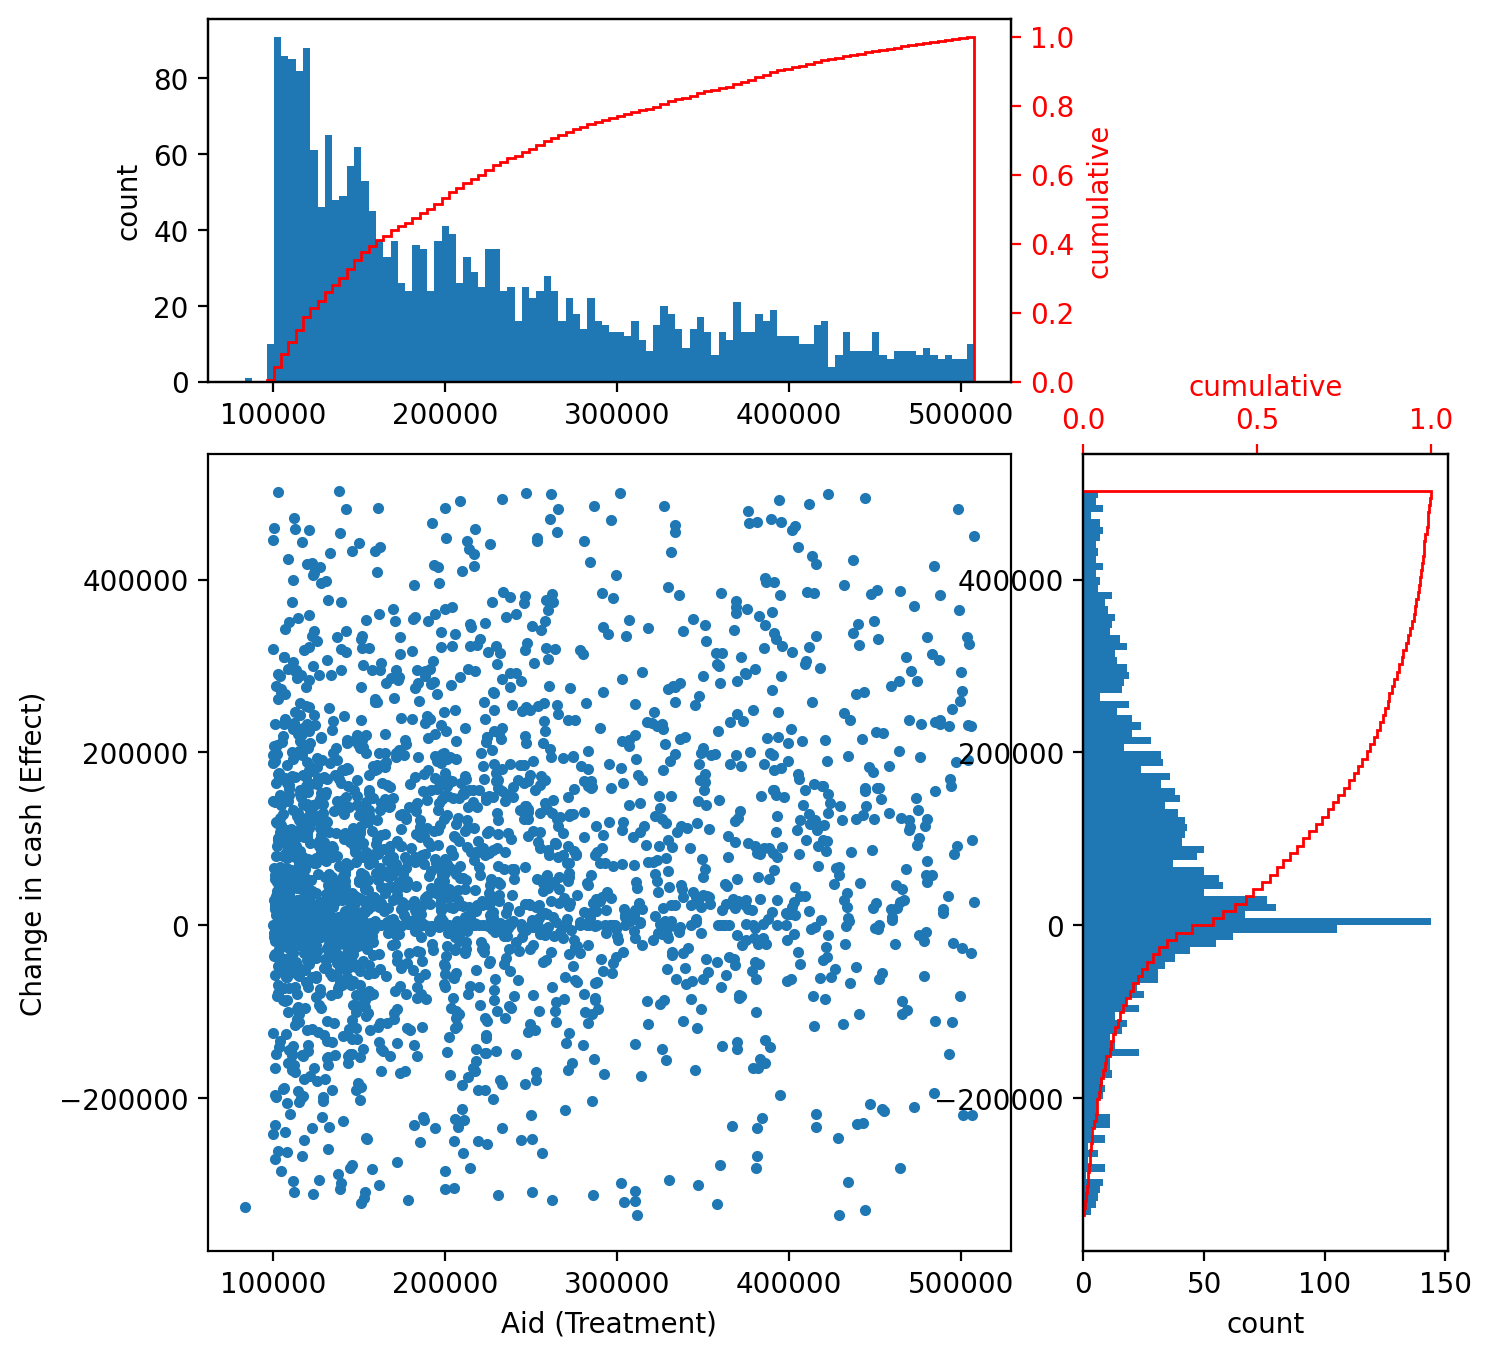

In [214]:
# https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = final_df[['grant_2021']]
y = final_df[['delta_cash_2021']]

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.scatter(x,y,marker='.')
ax_main.set(xlabel="Aid (Treatment)", ylabel="Change in cash (Effect)")

ax_xDist.hist(x,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')

plt.show()

### Old

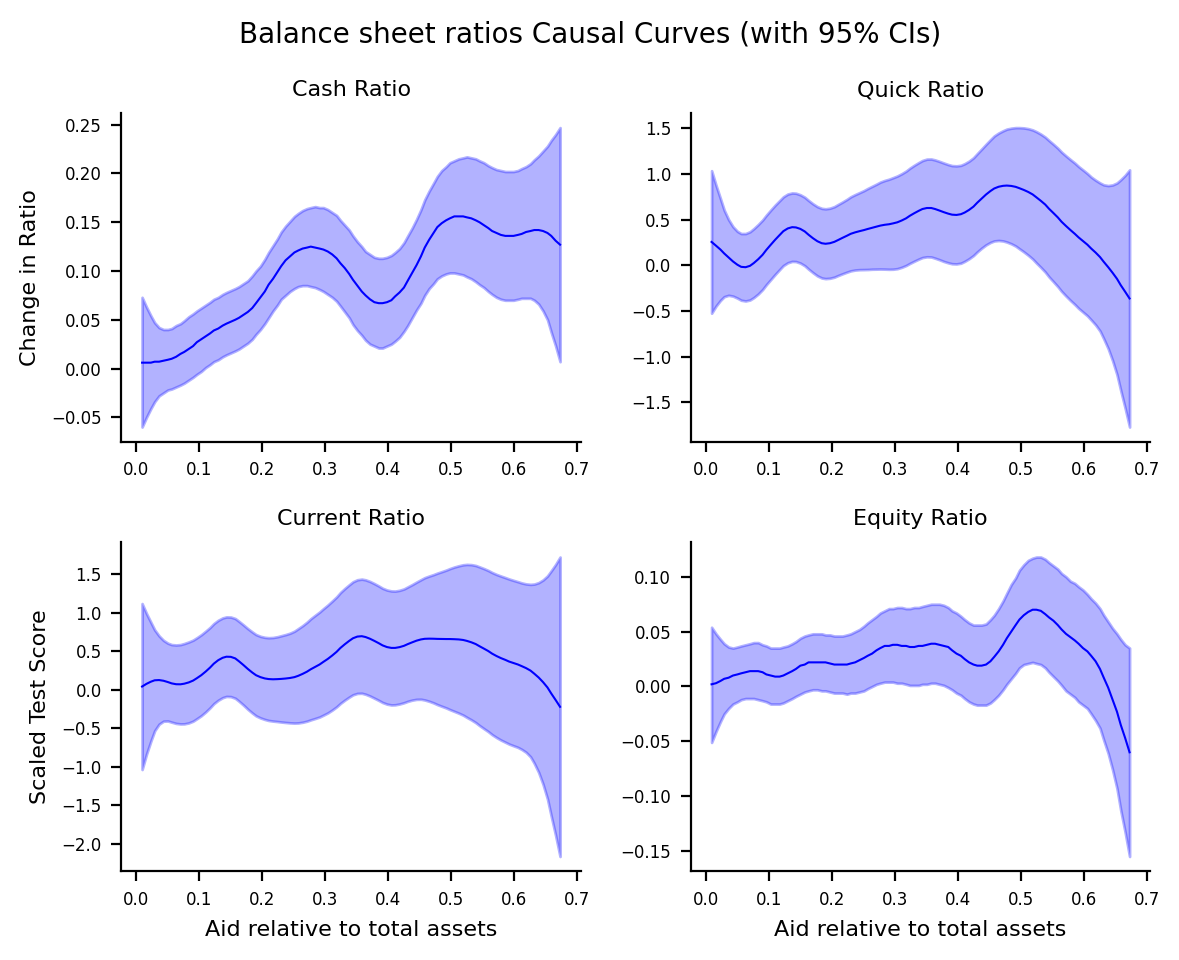

In [39]:
result_class = [['delta_cash_ratio_2021', 'delta_qick_ratio_2021'], ['delta_current_ratio_2021', 'delta_equity_ratio_2021']]

result_name = [['Cash Ratio', 'Quick Ratio'], ['Current Ratio', 'Equity Ratio']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Change in Ratio', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Aid relative to total assets', fontsize = 8)
        axs[1,1].set_xlabel('Aid relative to total assets', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        #axs[i,j].set_xlim(0, 2)
        #axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Balance sheet ratios Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)